## Match scheduling

Now that all subteams have been determined, we can start scheduling the matches between them.

:warning: Make sure to always restart the kernel after generating new subteams!

This process provides several challenges:

- We need to find a way for each subteam to play only against subteams form the other main teams, and this in a balanced manner.
- We need to consider that the same subteam can't play at two pitches at the same time.
- We need to look out for players that are doubly-booked and try to find workarounds.
- **Ping pong** is a big headache:
  - We want each player to have one match against one player of each of the other teams, but not have the other two players face each other to avoid grouping effects.
  - We want to schedule matches every day.
  - We want these matches to not overlap with any of the player's other activities.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import helper_functions as hf
from helper_functions import setup
from math import ceil, floor
from helper_functions.classes.sport_event import SportEvent
from helper_functions.setup.match_scheduling import determine_rotated_matchups_for_sport, write_match_backup
from helper_functions.classes.match import Match
from helper_functions.classes.player import Player
from helper_functions.setup.setup_util import update_player_signup_status
from itertools import combinations
import pandas as pd
from itertools import combinations
from datetime import datetime, timedelta, time, date
hf.LOGGER.setLevel("INFO")

NUM_TEAMS = 3


In [2]:

def reshuffle_list(list_to_shuffle: list, interval=2) -> list:
    """
    Reshuffles a list by taking elements at regular intervals and concatenating them.

    Parameters
    ----------
    list_to_shuffle (list): The list to be reshuffled.
    interval (int, optional): The interval at which elements are taken from the list. Default is 2.

    Returns
    -------
    list: The reshuffled list.

    Example
    -------
    >>> my_list = [1, 2, 3, 4, 5]
    >>> reshuffle_list(my_list, interval=3)
        --> [1, 4, 2, 5, 3]
    This is equivalent to --> my_list[::3] + my_list[1::3] + my_list[2::3]
    """
    slices = [slice(i, None, interval) for i in range(interval)]
    return [entry for my_slice in slices for entry in list_to_shuffle[my_slice]]

def schedule_matches(sport_event: SportEvent, shuffle_interval=2) -> list[Match]:
    subteams = hf.DATA_NOW.subteams
    matchups = determine_rotated_matchups_for_sport(subteams, sport_event.sanitized_name)
    # Shuffle them around a bit such that the same subteam doesn't have matches at the same time
    matchups = reshuffle_list(matchups, shuffle_interval)
    courts = [
        str(i + 1)
        for _ in range(len(matchups) // sport_event.num_pitches + 1)
        for i in range(sport_event.num_pitches)
    ]
    date_range = pd.date_range(
            start=sport_event.start,
            periods=len(matchups),
            freq=sport_event.match_duration,
        )
    dates = [
        date
        for date in date_range
        for _ in range(sport_event.num_pitches)
    ]
    matches = [Match(sport_event.sanitized_name, start, sport_event.match_duration, matchup[0], matchup[1], location) for start, matchup, location in zip(dates, matchups, courts)]
    return matches


### Checks and tweaks

Now that the matches (except for Ping Pong) are scheduled, we assess whether our scheduling algorithm has scheduled any matches with overlap.

I also try to switch a few matchup times around such that people don't have to wait 2h just to have the next matchup. This is a very manual process, we need to go through each of the sports (excluding the ones that at most have a waiting time of 30 mins, we don't care about those) and eyeball the subteams.

In [3]:
hf.DATA_NOW.reload()

ALL_MATCHES = {match.match_key: match
               for sport in hf.DATA_NOW.sport_events.values() 
               for match in schedule_matches(sport, 3 if sport.sanitized_name in ["chess", "badminton"] else 2) 
               if sport.sanitized_name not in ["ping_pong", "running_sprints"]
            }

sprints = hf.DATA_NOW.sport_events["running_sprints"]
subteams = [team for team in sprints.subteams if not team.is_reserve]
for comb in combinations(subteams, 2):
    match_ = Match("running_sprints", sprints.start, timedelta(minutes=90), comb[0], comb[1], "Main pitch")
    ALL_MATCHES[match_.match_key] = match_
hf.LOGGER.setLevel("WARNING")
ALL_MATCHES["football_B2_C2"].switch_with_other(ALL_MATCHES["football_C2_A1"])
ALL_MATCHES["football_B2_C2"].switch_with_other(ALL_MATCHES["football_A2_B2"])
ALL_MATCHES["football_B1_C1"].switch_with_other(ALL_MATCHES["football_C1_A2"])
ALL_MATCHES["capture_the_flag_A2_B2"].switch_with_other(ALL_MATCHES["capture_the_flag_A1_B1"])
ALL_MATCHES["capture_the_flag_A2_B2"].switch_with_other(ALL_MATCHES["capture_the_flag_C2_A2"])
ALL_MATCHES["tennis_A1_B1"].switch_with_other(ALL_MATCHES["tennis_B1_C4"])
ALL_MATCHES["tennis_A4_B3"].switch_with_other(ALL_MATCHES["tennis_C4_A3"])
# The following resolves some PP conflicts
ALL_MATCHES["foosball_A5_B6"].switch_with_other(ALL_MATCHES["foosball_C4_A3"])
ALL_MATCHES["football_B1_C1"].switch_with_other(ALL_MATCHES["football_C2_A1"])
ALL_MATCHES["chess_A6_B1"].switch_with_other(ALL_MATCHES["chess_B1_C5"])
ALL_MATCHES["foosball_C6_A4"].switch_with_other(ALL_MATCHES["foosball_B5_C1"])
hf.LOGGER.setLevel("INFO")

num_conflicts = np.sum([comb[0].has_hard_collision(comb[1], verbose=True) for comb in combinations(ALL_MATCHES.values(), 2)])


if num_conflicts == 0:
    print("Successfully removed all conflicts. Yay!")


match_df = pd.DataFrame.from_dict(ALL_MATCHES, orient="index")
match_df[match_df["sport"] == "spikeball"].sort_values("start")

sport = "foosball"
sport_matches =  [m for m in ALL_MATCHES.values() if m.sport == sport]
slots = np.unique([m.start for m in sport_matches])  # type: ignore
for slot in slots:
    print(slot)
    print("\t" + ", ".join([f"{m.subteam_a.short_key}_{m.subteam_b.short_key}" for m in sport_matches if m.start == slot]))


[sports_week: WARNING] - beer_pong_B5_C5, foosball_B1_C4: {'Cute Frog'} (B) have conflicting schedules (17:45, Friday, 18:00, Friday).
[sports_week: WARNING] - beer_pong_A3_B5, foosball_A1_B1: {'Cute Frog'} (B) have conflicting schedules (18:45, Friday, 19:00, Friday).
2025-05-09 17:30:00
	A3_B2, C5_A1
2025-05-09 17:45:00
	B3_C6, A6_B5
2025-05-09 18:00:00
	C1_A5, B1_C4
2025-05-09 18:15:00
	A4_B4, C3_A2
2025-05-09 18:30:00
	B6_C2, B2_C5
2025-05-09 18:45:00
	A2_B3, B5_C1
2025-05-09 19:00:00
	C6_A4, A1_B1
2025-05-09 19:15:00
	B4_C3, A5_B6
2025-05-09 19:30:00
	C4_A3, C2_A6


### Ping Pong

This is a whole different beast to tackle; with 75 players (and thus 75 matches) in 2025, we really needed to plan tight!

After having set all of the matches for the other sports, it should be easy to fit in the ping pong ones, right?

Weeell... there are a few hurdles to take first:

- Already, at an earlier sanitization step, we've removed Wednesday from the available days for Badminton players since they should not be required to switch over.
- The matchups themselves are not super straight-forward due to the constraints we have from the players. There are multiple ways to approach this problem: Either, you somehow ensure matchups are only possible taking the days into account from the get-go (which clashes with the way we set up the algorithm), or you just brute-force it, expecting it to somehow work out. We took the second approach, and of course it didn't - there were around 15 matches scheduled between players that had specified subsets of non-overlapping days. Well now one would think that of course we should just be reasonable and take the other approach, but no, we wanted to utilize yet another one (say, the brute brute force one): Here, we shuffle the teams' players before we start our match-up algorithm such that the match-ups are done differently, and just hope for the best. This obviously doesn't work right away, so we had to hunt for a nice seed that minimizes the players with failing match-ups. Indeed there is one such seed that only left three failed match-ups, and we then went and switched those manually (simply by switching one player with another one of the same team in a match-up where the overlap was all 5 days).
- Now that we had the match-ups (and the corresponding days their players were available), the task was to schedule them properly in the tight-knit net of already existing matches of other sports. To maximize the chances of success, we use a successive approach where we order the players by the amount of other sports they have, and then by the amount of days they specified for the ping pong to be okay for a given player.
- With this, we slowly fill the tight grid of available slots, taking into account the three tables we have.

In [23]:
from datetime import datetime, timedelta, time, date
from typing import Collection
def get_all_ping_pong_timeslots(avail_days: Collection[str], taken_slots: list[datetime] | None = None) -> list[datetime]:
    """Retrieve all possible timeslots for the given available weekdays.

    Filters out any slots in 'taken_slots' if provided, and returns a list of available timeslots.
    """
    event = hf.DATA_NOW.sport_events["ping_pong"]
    match_dur = event.match_duration
    start_time = event.start.time()
    avail_time = event.end - datetime.combine(event.end.date(), start_time)
    avail_match_slots_per_day = floor(avail_time/match_dur)
    all_timeslots = []
    for day in hf.DATA_NOW.days:
        if day.strftime("%A").lower() not in avail_days:
            continue
        start = datetime.combine(day, start_time)
        all_timeslots += [start + match_dur*i for i in range(avail_match_slots_per_day)]
    if taken_slots is None:
        return all_timeslots
    # Triple the amount of slots to account for the fact that we have 3 tables, then take away one slot for each taken slot
    all_timeslots *= 3
    for slot in taken_slots:
        if slot in all_timeslots:
            all_timeslots.remove(slot)
    return sorted(all_timeslots)

def get_weekdays_for_sports(sports: list[str]) -> list[str]:
    """Retrieve the weekdays the given sports take place on."""
    return [day for event in hf.DATA_NOW.sport_events.values() for day in event.days if event.sanitized_name in sports]


# Esample usage
get_all_ping_pong_timeslots(["monday"], taken_slots=[datetime(2025, 5, 5, 18, 10)]);


In [24]:
all_players = hf.DATA_NOW.players.set_index("nickname").fillna("")
def perform_shuffled_matchups(seed: int = 42) -> int:
    matchups = determine_rotated_matchups_for_sport(hf.DATA_NOW.subteams, "ping_pong", seed)

    num_fails = 0
    for matchup in matchups:
        match_players = all_players.loc[matchup[0].players + matchup[1].players]
        p1, p2 = match_players.iloc[0], match_players.iloc[1]
        common_days = set(eval(p1["ping_pong_days"])).intersection(eval(p2["ping_pong_days"]))
        if len(common_days) == 0:
            num_fails += 1
    return num_fails

def find_best_seed(num_iter: int = 1000) -> int:
    best_fail_num = 10
    best_seed = -1
    for i in range(num_iter):
        num_fails = perform_shuffled_matchups(i)
        if num_fails < best_fail_num:
            print(f"Seed {i} -> {num_fails}")
            best_fail_num = num_fails
            best_seed = i
    return best_seed

def _get_subteam(p: pd.Series) -> str:
    return p["Team"] + p["subteam_ping_pong"]

def _get_combined_key(matchup_tup: tuple[hf.Subteam, hf.Subteam]) -> str:
    return matchup_tup[0].short_key + "_" + matchup_tup[1].short_key

def switch_internal_matchup(key_a: str, key_b: str, all_ms: list[tuple[hf.Subteam, hf.Subteam]]) -> list[tuple[hf.Subteam, hf.Subteam]]:
    idx1 = np.where([_get_combined_key(m) == key_a for m in all_ms])[0][0]
    idx2 = np.where([_get_combined_key(m) == key_b for m in all_ms])[0][0]
    # Swap the tuples, exchanging the first matchup
    all_ms[idx1], all_ms[idx2] = (all_ms[idx2][0], all_ms[idx1][1]), (all_ms[idx1][0], all_ms[idx2][1])
    return all_ms

# Quick seed-hunting revealed 497 to be the best seed to have as little clashes as possible
matchups = determine_rotated_matchups_for_sport(hf.DATA_NOW.subteams, "ping_pong", 497)
# I determined which matchups to switch by first taking those that didn't work out (0 common days), and then those that were completely flexible (5 common days). Then I only needed to make sure their main teams were the same.
switch_internal_matchup("B22_C22", "B02_C20", matchups)
switch_internal_matchup("A09_B20", "A15_B02", matchups)
switch_internal_matchup("A23_B09", "A18_B07", matchups)
switch_internal_matchup("B17_C19", "B03_C07", matchups)
switch_internal_matchup("C23_A01", "C11_A07", matchups)
switch_internal_matchup("C09_A12", "C20_A11", matchups)
# The ones below ensure that on Friday (which was busiest), more people that only have time on friday compete with other people that only have time on friday:
switch_internal_matchup("C08_A22", "C15_A25", matchups)
switch_internal_matchup("A10_B12", "A03_B18", matchups)
switch_internal_matchup("B01_C13", "B07_C15", matchups)
switch_internal_matchup("C07_A10", "C15_A22", matchups)
switch_internal_matchup("A09_B02", "A04_B01", matchups)
switch_internal_matchup("A19_B19", "A14_B13", matchups)
switch_internal_matchup("C08_A25", "C10_A19", matchups)



for matchup in matchups:
    match_players = all_players.loc[matchup[0].players + matchup[1].players]
    p1, p2 = match_players.iloc[0], match_players.iloc[1]
    common_days = set(eval(p1["ping_pong_days"])).intersection(eval(p2["ping_pong_days"]))
    if len(common_days) == 0:
        # print(p1["ping_pong_days"], p2["ping_pong_days"])
        print("CLASHING: ", _get_subteam(p1), _get_subteam(p2))
    if len(common_days) == 4:
        print("Completely flexible: ", _get_subteam(p1), _get_subteam(p2))


Completely flexible:  Team A4 Team B2
Completely flexible:  Team C7 Team A22
Completely flexible:  Team C24 Team A14
Completely flexible:  Team B7 Team C13
Completely flexible:  Team A14 Team B19
Completely flexible:  Team B21 Team C1


Distribution for how many completely free days are available for matchups:
	47 (0), 21 (1), 5 (2), 2 (3)
We need to schedule ~15 matches each day, and the availabilities are as follows:
['monday: 29', 'tuesday: 35', 'wednesday: 16', 'thursday: 25', 'friday: 37']


,a,player_a,b,player_b,avail_days,busy_days,free_days,a_days,b_days,match_key
12,A10,Worthy Aurochs,B18,Joyful Echidna,{friday},"{monday, friday}",{},[friday],[friday],A10_B18
13,B18,Joyful Echidna,C08,Appropriate Tang,{friday},"{monday, wednesday, friday}",{},[friday],[friday],B18_C08
29,C18,Noted Hippopotamus,A18,Crooked Leopard,{friday},{wednesday},{friday},"[wednesday, friday]","[monday, tuesday, thursday, friday]",C18_A18
37,B01,Ill-fated Meerkat,C15,Numb Goat,{friday},"{monday, wednesday, friday}",{},[friday],[friday],B01_C15
39,A09,Shallow Anteater,B01,Ill-fated Meerkat,{friday},"{monday, thursday, wednesday}",{friday},[friday],[friday],A09_B01
42,A19,Mushy Sparrow,B13,Spanish Ferret,{friday},"{monday, thursday, wednesday, friday}",{},[friday],[friday],A19_B13
43,B13,Spanish Ferret,C03,Prize Jerboa,{friday},"{monday, wednesday, thursday}",{friday},[friday],[friday],B13_C03
44,C03,Prize Jerboa,A06,Kooky Snake,{friday},"{thursday, tuesday, wednesday, friday}",{},[friday],"[tuesday, wednesday, thursday, friday]",C03_A06
47,C08,Appropriate Tang,A19,Mushy Sparrow,{friday},"{monday, thursday, wednesday, friday}",{},[friday],[friday],C08_A19
60,A24,Deserted Chimpanzee,B25,Overlooked Bobcat,{friday},"{thursday, wednesday, friday}",{},"[monday, thursday, friday]",[friday],A24_B25


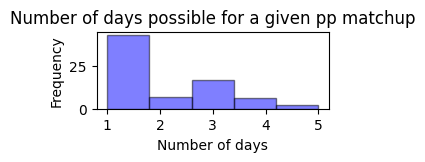

In [25]:
from typing import Literal
def _get_overlapping_pp_days(p1: str, p2: str) -> set[Literal["monday", "tuesday", "wednesday", "thursday", "friday"]]:
    p1_days = eval(all_players.loc[p1]["ping_pong_days"])  # type: ignore
    p2_days = eval(all_players.loc[p2]["ping_pong_days"])  # type: ignore
    return set(p1_days).intersection(p2_days)
def _get_player(p: str) -> hf.Player:
    return all_players.loc[p]

def _get_busy_days(p1: str, p2: str) -> set[str]:
    events = [e for e in hf.DATA_NOW.sport_events.values() if e.sanitized_name != "ping_pong"]
    p1_days = {s.days[0] for s in events if all_players.loc[p1][s.sanitized_name]}
    p2_days = {s.days[0] for s in events if all_players.loc[p2][s.sanitized_name]}
    return p1_days.union(p2_days)

df = pd.DataFrame([[m[0].short_key, m[0].players[0], m[1].short_key, m[1].players[0]] for m in matchups], columns=["a", "player_a", "b", "player_b"])
df["avail_days"] = df.apply(lambda r: _get_overlapping_pp_days(r["player_a"], r["player_b"]), axis=1)
df["busy_days"] = df.apply(lambda r: _get_busy_days(r["player_a"], r["player_b"]), axis=1)
df["free_days"] = df["avail_days"] - df["busy_days"]
df["a_days"] = df["player_a"].apply(lambda p: eval(_get_player(p)["ping_pong_days"]))
df["b_days"] = df["player_b"].apply(lambda p: eval(_get_player(p)["ping_pong_days"]))
u, c = np.unique(df["free_days"].apply(len), return_counts=True)
print("Distribution for how many completely free days are available for matchups:\n\t" + ", ".join([f"{v} ({k})" for k, v in zip(u, c)]))
df["avail_days"].apply(len).plot.hist(bins=5, alpha=0.5, color="blue", edgecolor="black")

plt.title("Number of days possible for a given pp matchup")
plt.xlabel("Number of days")
plt.locator_params(axis="x", nbins=5)
plt.gcf().set_size_inches(3, 1)
weekdays = ["monday", "tuesday", "wednesday", "thursday", "friday"]
counts = [np.sum(df["avail_days"].apply(lambda s: day in s)) for day in weekdays]
m_per_day = ceil(np.sum(hf.DATA_NOW.players["ping_pong"])/5)
print(f"We need to schedule ~{m_per_day} matches each day, and the availabilities are as follows:")
print([f"{d}: {c}" for d, c in zip(weekdays, counts)])
df["match_key"] = df.apply(lambda r: f"{r['a']}_{r['b']}", axis=1)
df[df["avail_days"].apply(lambda days: len(days) == 1 and "friday" in days) ]




In [26]:

def _determine_avail_times(p1: str, p2: str, taken_slots: list[datetime] | None = None, other_pp_matches: list[Match] | None = None) -> list[datetime]:
    """For a given matchup of p1 and p2, determine all common timeslots for which they would both be available.
    These timeslots correspond to start times of matches."""
    # Ensure that no player gets scheduled for a match at the same time they're already playing:
    if other_pp_matches is not None and taken_slots is not None:
        for match in other_pp_matches:
            players = match.involved_players
            if (p1 in players) or (p2 in players):
                # Cannot mutate 'taken_slots', we have to overwrite it to avoid ghost bugs
                taken_slots = taken_slots.copy() + [match.start]*3
    overlap = _get_overlapping_pp_days(p1, p2)
    busy = _get_busy_days(p1, p2)
    preferred = overlap - busy
    if len(preferred) > 0:
        return get_all_ping_pong_timeslots(preferred, taken_slots)
    timeslots = get_all_ping_pong_timeslots(overlap, taken_slots)
    relevant_matches = [m for m in ALL_MATCHES.values() if (m.contains_player(p1) or m.contains_player(p2)) and m.start.strftime("%A").lower() in overlap]
    # We want every player to have at least 15 minutes to switch between ping pong and their other sport.
    buffer = timedelta(minutes=15)
    busy_times = [(m.start - buffer, m.end + buffer) for m in relevant_matches]
    # print("\n".join([str((bt[0], bt[1])) for bt in busy_times]))
    match_dur = hf.DATA_NOW.sport_events["ping_pong"].match_duration
    avail_times = []
    for t in timeslots:
        if any([(t + match_dur > bt[0]) and (t < bt[1]) for bt in busy_times]):
            continue
        avail_times.append(t)
    return avail_times


df["avail_times"] = df.apply(lambda r: _determine_avail_times(r["player_a"], r["player_b"]), axis=1)
np.unique(df["avail_times"].apply(len), return_counts=True)
df[df["avail_times"].apply(len) == 1].sort_values("avail_times")


,a,player_a,b,player_b,avail_days,busy_days,free_days,a_days,b_days,match_key,avail_times
50,C11,Poor Hamster,A01,Monstrous Jackal,{monday},"{monday, wednesday, tuesday}",{},"[monday, tuesday, wednesday, thursday, friday]",[monday],C11_A01,[2025-05-05 20:15:00]
58,B05,Silent Wolffish,C16,Electric Rat,{monday},"{monday, thursday, wednesday, friday}",{},[monday],"[monday, tuesday, wednesday, thursday, friday]",B05_C16,[2025-05-05 20:15:00]
52,B04,Blank Tiffany,C25,Clumsy Lizard,{tuesday},"{monday, tuesday}",{},[tuesday],"[monday, tuesday]",B04_C25,[2025-05-06 19:00:00]
67,B17,Possible Anchovies,C07,Pushy Bulldog,{wednesday},"{monday, thursday, tuesday, wednesday, friday}",{},[wednesday],"[monday, tuesday, wednesday, thursday, friday]",B17_C07,[2025-05-07 20:15:00]
47,C08,Appropriate Tang,A19,Mushy Sparrow,{friday},"{monday, thursday, wednesday, friday}",{},[friday],[friday],C08_A19,[2025-05-09 20:15:00]


By some deliberate movement further up in the pipeline (when scheduling the other sports), we tried to minimize the players who have just a single ping pong time slot available.

The next step is to finally schedule each ping pong match, which we tackle as follows:

- We fill the dict of ping pong matches one by one.
- For this, we sort the ping-pong match dataframe by the amount of available time slots after each iteration, taking into account the time slots that are taken up by the previously scheduled matches.
- Each timeslot has up to three matches (= three tables available) that can be scheduled.

In [27]:
import random

random.seed(10)
PP_DURATION = hf.DATA_NOW.sport_events["ping_pong"].match_duration
PING_PONG_MATCHES = {}

default_start = datetime(2025, 5, 5, 10)

def schedule_next_match(matches: dict, matchup_df: pd.DataFrame) -> tuple[Match, pd.DataFrame]:
    """Schedule the next match based on the current taken slots."""
    taken_slots = [m.start for m in matches.values()]
    matchup_df["avail_times"] = matchup_df.apply(lambda r: _determine_avail_times(r["player_a"], r["player_b"], taken_slots, matches.values()), axis=1)
    matchup_df["num_avail_times"] = matchup_df["avail_times"].apply(len)
    idx = 0
    next_row = matchup_df.sort_values("num_avail_times").iloc[idx]
    key_a, key_b = f"ping_pong_{next_row["a"]}", f"ping_pong_{next_row["b"]}"
    st_a, st_b = hf.DATA_NOW.subteams[key_a], hf.DATA_NOW.subteams[key_b]
    # Choose the timeslot that currently does have the least occupations, otherwise random.
    avail_times = next_row["avail_times"]
    if len(avail_times) == 0:
        days = [hf.DATA_NOW.get_day(d) for d in  _get_overlapping_pp_days(next_row["player_a"], next_row["player_b"])]
        times = [datetime.combine(d, time(17, 15)) for d in days]
        avail_times = avail_times + times
        hf.LOGGER.warning(f"Couldn't schedule match for {next_row['player_a']} and {next_row['player_b']}, choosing one of {avail_times} instead")
        # return Match("ping_pong", default_start, PP_DURATION, st_a, st_b, "not sure"), matchup_df.drop(next_row.name)
    avail_time_counts = {t: avail_times.count(t) for t in avail_times}
    # Take the timeslot with the highest amount of times:
    next_slot = max(avail_time_counts, key=avail_time_counts.get)  # type: ignore
    # If there are multiple with the same amount, take a random one:    
    location = str(taken_slots.count(next_slot)+1)
    next_match = Match("ping_pong", next_slot, PP_DURATION, st_a, st_b, location)
    # Remove the match from the dataframe to avoid scheduling it again
    return next_match, matchup_df.drop(next_row.name)

MATCHUP_DF = df.copy()
# Array to track occupation:
arr = np.zeros([5, 7, 3], dtype=bool) # 5 days, 7 timeslots, 3 courts
pp_start = hf.DATA_NOW.sport_events["ping_pong"].start.time()
pp_dur = hf.DATA_NOW.sport_events["ping_pong"].match_duration

arrays = [arr.copy()]
while len(MATCHUP_DF) > 0:
    match, MATCHUP_DF = schedule_next_match(PING_PONG_MATCHES, MATCHUP_DF)
    PING_PONG_MATCHES[match.match_key] = match
    if match.location == "not sure":
        arrays.append(np.ones_like(arr, dtype=bool))
        continue
    day = match.start.weekday()
    rel_start_time = (match.start - datetime.combine(match.start.date(), pp_start))
    time_slot = int(rel_start_time / pp_dur)
    court = int(match.location) - 1
    arr[day, time_slot, court] = True
    arrays.append(arr.copy())

# Pad the array with the last image for a few frames:
arrays.extend([arrays[-1]]*20)


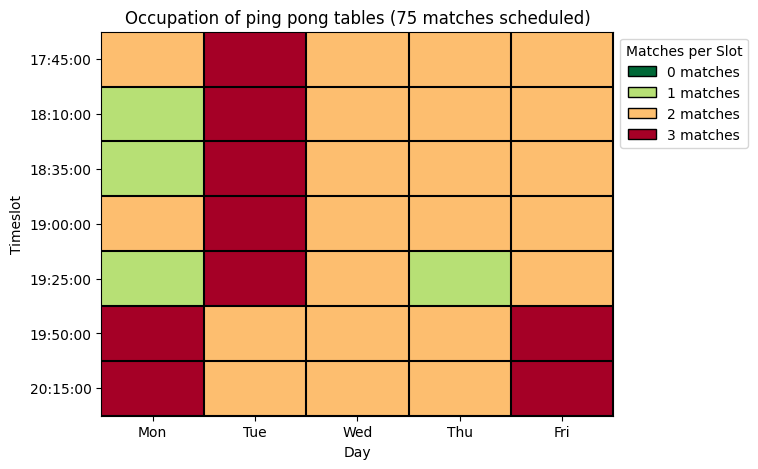

In [32]:
from matplotlib.axes import Axes
from matplotlib.patches import Patch
from matplotlib import colormaps

def add_custom_legend(cmap: str) -> None:
    legend_labels = [f"{i} matches" for i in range(4)]
    legend_colors = [colormaps[cmap](v) for v in np.linspace(0, 1, 4)]
    patches = [Patch(facecolor=color, label=label, edgecolor="k") for color, label in zip(legend_colors, legend_labels)]
    plt.legend(handles=patches, title="Matches per Slot", loc="upper left", bbox_to_anchor=(1, 1))


def visualize_match_array(arr: np.ndarray, ax: Axes, cmap="RdYlGn_r") -> None:
    days, timeslots, courts = arr.shape
    
    img = np.sum([1*arr[:, :, i].T for i in range(courts)], axis=0)
    # Invert the y-axis:
    # img = img[::-1,:]
    # img[0, 0] = 0
    ax.imshow(img, cmap=cmap, aspect="auto", vmin=0, vmax=3)
    ax.set_title(f"Occupation of ping pong tables ({img.sum()} matches scheduled)")
    ax.set_xlabel("Day")
    ax.set_ylabel("Timeslot")
    ax.set_xticks(range(days))
    ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri"])
    ax.set_yticks(range(timeslots))
    ax.set_yticklabels([t.time() for t in get_all_ping_pong_timeslots(["monday"])])
    ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7, which="minor")
    for i in range(days):
        ax.axvline(i+0.5, color="k")
    for i in range(timeslots):
        ax.axhline(i+0.5, color="k")
    # Custom legend:
    add_custom_legend(cmap)

fig, ax = plt.subplots()
visualize_match_array(arrays[-1], ax, "RdYlGn_r")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  


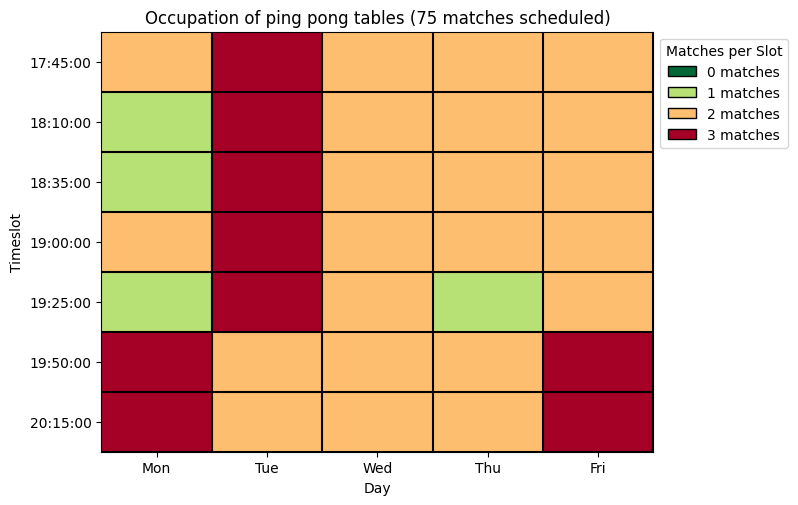

In [34]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from pathlib import Path

def create_gif(arrays: list[np.ndarray], output_file: Path |str, cmap: str = "hot_r") -> None:
    """
    Create a GIF cycling through the arrays using the visualize_match_array function.

    Parameters
    ----------
    arrays : list[np.ndarray]
        List of 3D arrays to visualize.
    output_file : str
        Path to save the generated GIF.
    cmap : str, optional
        Colormap to use for visualization, by default "hot_r".
    """
    fig, ax = plt.subplots(figsize=(8, 5))

    def update(frame: int) -> None:
        ax.clear()
        visualize_match_array(arrays[frame], ax, cmap=cmap)

    ani = FuncAnimation(fig, update, frames=len(arrays), interval=200, repeat=False)
    plt.subplots_adjust(left=0.13, right=0.82, top=0.94, bottom=0.1) 
    writer = PillowWriter(fps=5)
    ani.save(output_file, writer=writer)  # Save as GIF

# Example usage:
create_gif(arrays, hf.FpathRegistry.get_path_matches().parent.joinpath("ping_pong_scheduling_vis.gif"), cmap="RdYlGn_r")


In [105]:
p = hf.DATA_NOW.teams[0].player_df.set_index("nickname")
mask = p["ping_pong"]
mask &= p["ping_pong_days"].apply(lambda x: "friday" in x)
mask &= ~p["football"] & ~p["tennis"]
p[mask][[c for c in p.columns if "subt" in c]]
player  = "Thankful Kakapo"
print(hf.DATA_NOW.players[hf.DATA_NOW.players["nickname"] == player].iloc[0]["ping_pong_days"])
[k for k, m in ALL_MATCHES.items() if player in m.subteam_a.players or player in m.subteam_b.players]


['monday', 'tuesday', 'wednesday', 'thursday', 'friday']


['volleyball_A4_B3',
 'volleyball_B3_C2',
 'football_A1_B1',
 'football_B1_C1',
 'spikeball_A4_B2',
 'spikeball_B2_C3',
 'capture_the_flag_A2_B2',
 'capture_the_flag_B2_C1',
 'beer_pong_B6_C3',
 'beer_pong_A5_B6']

In [ ]:
# Final check for players that play both Badminton and Ping Pong, whether those have any clashes
set([p for m in PING_PONG_MATCHES.values() if m.start.strftime("%A") == "Wednesday" for p in m.involved_players]).intersection(hf.DATA_NOW.players[hf.DATA_NOW.players["badminton"]]["nickname"])


set()

In [30]:

full_match_dict = ALL_MATCHES | PING_PONG_MATCHES

write_match_backup(list(full_match_dict.values()), overwrite=True)


[sports_week: INFO] - Wrote new backup, scheduling 216 matches.
